In [4]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
import cartopy.feature as cfeature
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy


#Trend
#import xarrayMannKendall as XMK
import dask
from dask import delayed



import os
os.chdir(r"G:\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\2_Papers\1_Streamflow Trend analysis")
print(os.getcwd())

G:\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\2_Papers\1_Streamflow Trend analysis


### 1. Data processing 

In [36]:
sf_d=xr.open_mfdataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')
sf_M=sf_d['streamflow'].resample(time='M').sum().compute()


# Change all months to nan if any nan is present in a year. Otherwise each year wont have 12 months and result doesnt have uniformity
def set_nan_per_year(group):
    if np.isnan(group).any():
        return group.where(False)  # Replace all with NaN for this year
    return group

sf_p = []
for st in sf_M.station:
    station_data = sf_M.sel(station=st)
    processed_data = station_data.groupby('time.year').map(set_nan_per_year)
    sf_p.append(processed_data)

SF = xr.concat(sf_p, dim='station')
SF['station'] = sf_M['station']


### 2. Calculation of entropy


In [148]:
Xk=SF.groupby('time.year').sum()
Xk_m=SF.groupby('time.year')/Xk

AE1=-Xk_m*(np.log2(Xk_m))
AE=AE1.groupby('time.year').sum()
AE=AE.where(AE !=0,np.nan)

c:\Users\2024CEZ8029\anaconda3\envs\imed\Lib\site-packages\xarray\core\computation.py:761: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


### 3. Trend analysis

In [75]:
guage_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')
station=AE.station.values
index=['Afortionment Entropy']
MK=['slope','p_value']

d_arr1=xr.DataArray(coords={'station':station},dims=['station'],name='trend')
d_arr2=xr.DataArray(coords={'station':station},dims=['station'],name='p_value')
ds_mk=xr.Dataset({'trend':d_arr1,'p_value':d_arr2})

idx=0
result=[]
trnd = pd.DataFrame(index= station)
for stn in station:

        data1=AE.sel(station=stn).values
        trend1, h1, p1, z1, Tau1, s1, var_s1, slope1, intercept1 = mk.original_test(data1)
        ds_mk['trend'].loc[{ 'station': stn}] =(slope1/np.nanmean(data1))*1000
        ds_mk['p_value'].loc[{ 'station': stn}] = p1
            
#ds_mk.to_netcdf(r'2_Streamflow_Analysis\3_Trend analysis\output\Gauge_indices_trend.nc')




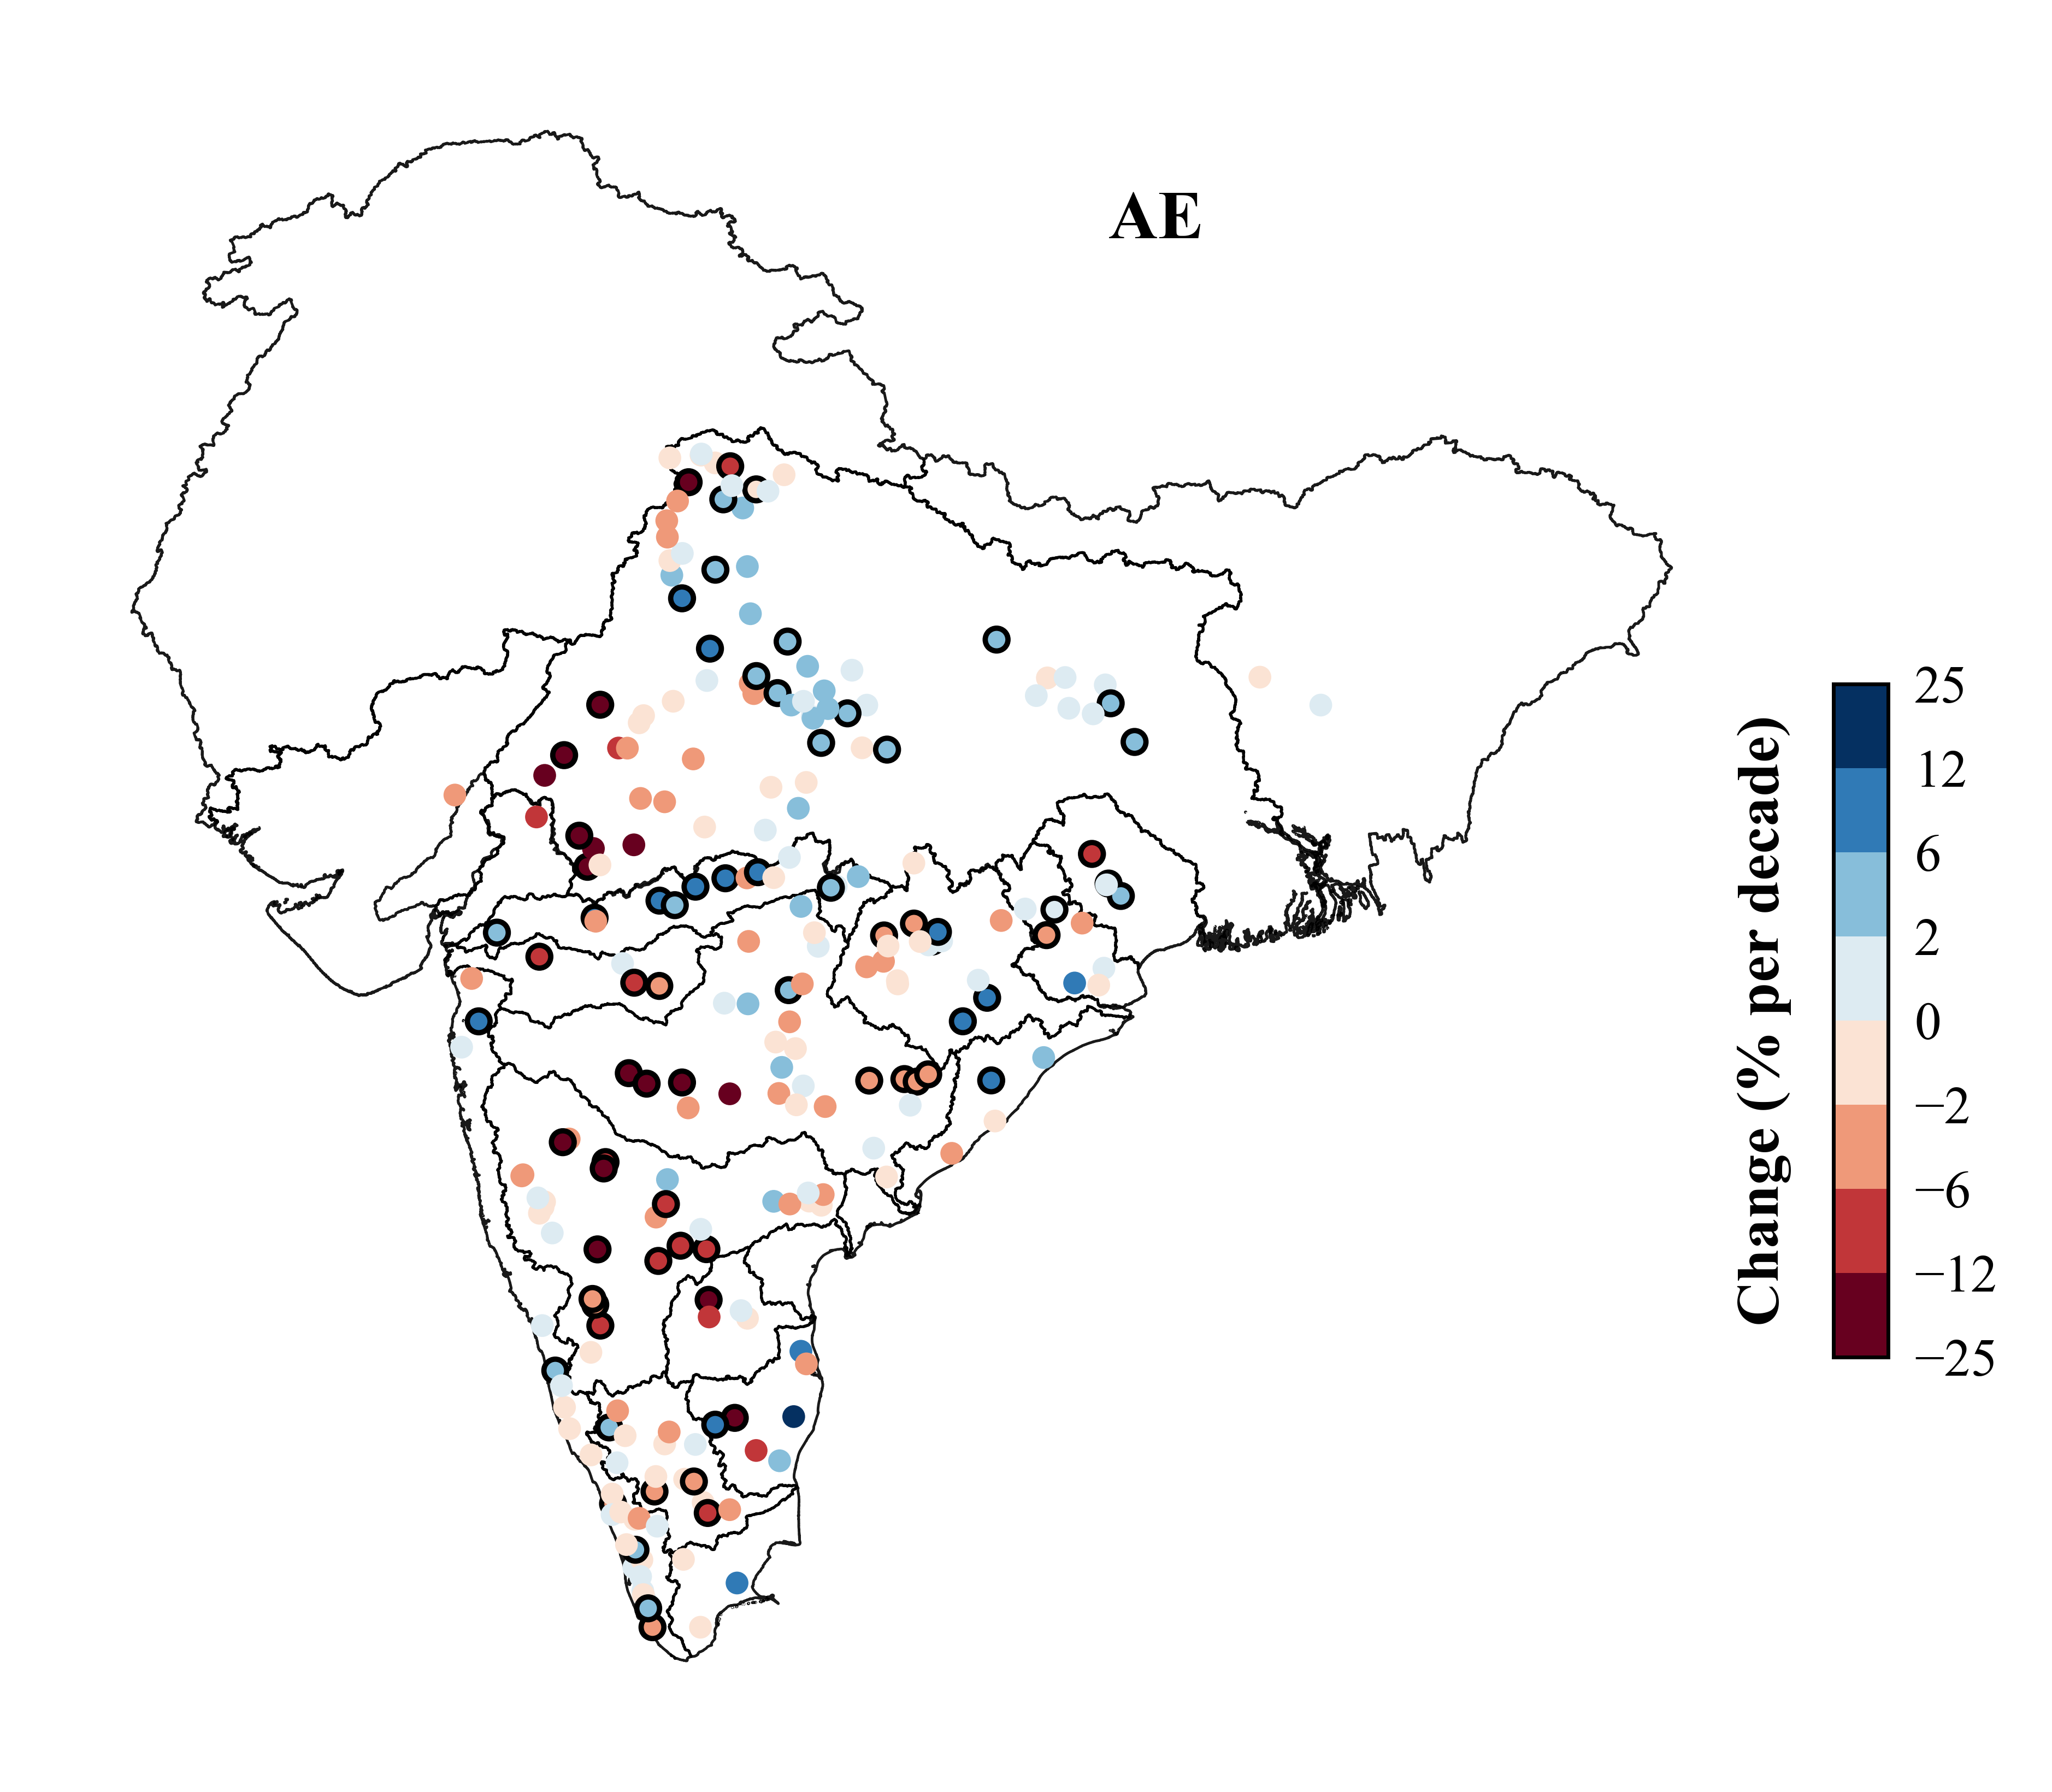

In [77]:
import scienceplots
import matplotlib.image as mpimg
from matplotlib.colors import BoundaryNorm
plt.rcParams['font.family'] = 'Times New Roman'

#plt.style.use(['science','no-latex','bright'])
#plt.rcParams['font.family'] = 'sans-serif'
#plt.rcParams['font.sans-serif'] = [  'DejaVu Sans', 'Bitstream Vera Sans', 'sans-serif']


num_colors = 50;marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
basinEdge = 'black';basinEdge1 = 'blue';basinLine = 0.35


# Loading maps
guage_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')
guage_info=guage_info[['GaugeID', 'Station', 'Latitude', 'Longitude']]
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

basin_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/IndiShape/IndShape.shp')
riv_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/India_streams/India_stream.shp')
ind_map=gpd.read_file('3_Data/DATA_r/3_shapefiles_new/india_admin/Country/India_country.shp')



fig, ax1 = plt.subplots(figsize=(10,4), subplot_kw={"projection": ccrs.PlateCarree()},dpi=1000)
i=0


guage_info['trend']=ds_mk['trend']
guage_info['p_value']=ds_mk['p_value']
guage_info['edge']=np.where(guage_info['p_value']<0.05,0.7,0)           # To mark circle in significance points

#Axis setting
[x.set_visible(False) for x in ax1.spines.values()]
[x.set_linewidth(0.1) for x in ax1.spines.values()]


#####Plot#####
cmap1='RdBu'
levels = [-25,-12,-6,-2,0,2,6,12,25]
cmap = plt.get_cmap(cmap1)
#norm = PowerNorm(gamma=0.5, vmin=min(levels), vmax=max(levels)) 
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

south_asia.plot(ax=ax1,color = 'none',edgecolor = basinEdge,linewidth=basinLine,alpha=0.9)
#ind_map.plot(ax=ax1,color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
#riv_map.plot(ax=ax1,color = 'blue',alpha=0.8,linewidth=basinLine*0.1)
#xrr2['trend'].plot(ax=ax1,cmap='RdBu',vmin=-0.02,vmax=0.02)

c1=np.repeat(['white'],len(guage_info['Latitude']))
sc=ax1.scatter(guage_info['Longitude'],guage_info['Latitude'],edgecolor='black', linewidth=guage_info['edge'],c=guage_info['trend'],s=9,cmap=cmap1,norm=norm)
# Add gridlines and titles for better readability


## Texts
ax1.text(0.65, 0.9, 'AE', fontsize=9, color='black',fontname='Times New Roman',weight='bold',
        transform=ax1.transAxes, ha='center', va='center')



# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=None, left=None, top=None, right=None, wspace=0.01, hspace=0.01)  



##### colorbar #######
lf=ax1.get_position().x0
bt=ax1.get_position().y0
wd=ax1.get_position().width
hg=ax1.get_position().height
cbar_ax = fig.add_axes([lf+wd*1.05, bt + 0.174, 0.01,hg-hg*0.6])
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='vertical', fraction=0.036, pad=0.04)
cbar.set_label('Slope')

cbar.outline.set_linewidth(0.5) 
cbar.ax.tick_params(axis='both',which='both', labelsize=7,width=2, length=0) 
cbar.ax.yaxis.set_label_position('left')
cbar.set_label("Change (% per decade)", fontsize=8, labelpad=5.5,weight='bold')
#cbar.ax.xaxis.label.set_fontweight('bold')

# Customize tick labels
#ticks = [-10,0, 10]
#cbar.set_ticks(ticks)
#cbar.set_ticklabels([str(tick) for tick in ticks])
#plt.tight_layout()


plt.savefig(r'2_Streamflow_Analysis\4_assymetric\Outputs\AE_trend.jpeg', bbox_inches='tight',dpi=1000)

## 4. Timeseries of selected station

In [ ]:
# Merging AE and streamflow timeseries 
sf_M['time']=np.array(pd.date_range('1970-01','2021-02',freq='M'))


# Cnverting the yearly AE to timeseries and each yearly value is assigned to the 7th month and all other months are assigned nan - for timeseries plotting purpose
AE_ren = AE.rename({"year": "time"})
AE_ren['time']=np.array(pd.date_range('1970-01','2022-01',freq='A-JAN'))
AE_ren=AE_ren.resample(time="M").ffill()
AE_final = AE_ren.where(AE_ren.time.dt.month == 7, np.nan)

ds=xr.Dataset({'streamflow' : sf_M,'AE' : AE_final})



<xarray.DataArray 'streamflow' (station: 241, time: 613)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * station  (station) object 'Chennur' 'Tadipatri' ... 'joshimath' 'Hasimara'
  * time     (time) datetime64[ns] 1970-01-31 1970-02-28 ... 2021-01-31

In [221]:
trn_sig[0:10]



,trend,p_value
station,,
Mandleshwar,11.400682,2.955409e-10
Takli,-16.162566,3.213267e-08
Sarati,-14.282580,7.643614e-08
Jagdalpur,-5.859446,3.195051e-07
Mantralayam,-7.788867,4.252452e-07
Hoshangabad,8.979505,1.272625e-06
paonta,-14.998832,1.826945e-06
Yelli,-19.282128,1.877629e-06
Barmanghat,10.793550,2.165572e-06


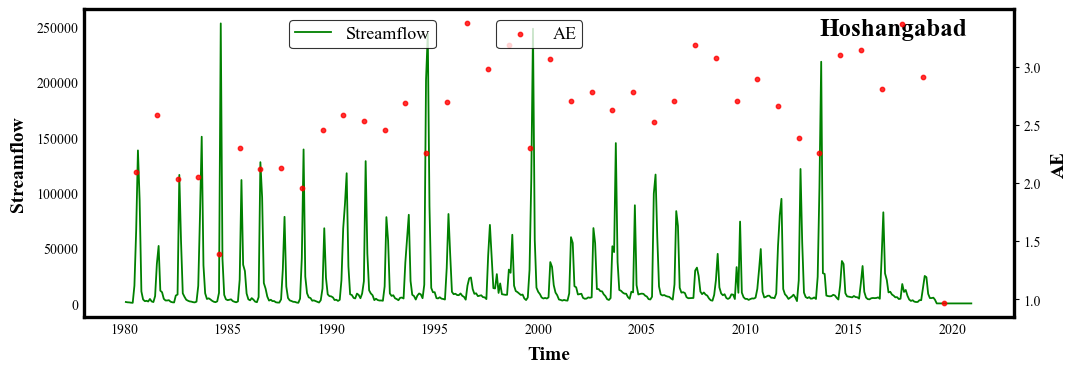

In [223]:
df=ds_mk.to_dataframe()
trn_sig=df[df['p_value']<0.05].sort_values(by='p_value', ascending=True)

station_new=trn_sig.index



plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.serif"] = "Times New Roman"


tim=pd.date_range(start="1980-01", end="2020-12", freq="M").to_numpy(dtype='datetime64[ns]')
df=pd.DataFrame(index=tim,columns=['streamflow','AE'])


stn=station_new[5]
df['streamflow']=ds['streamflow'].sel(station=stn,time=tim)
df['AE']=ds['AE'].sel(station=stn,time=tim)

fig, ax1 = plt.subplots(1, 1, figsize=(12,4))

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.serif"] = "Times New Roman"

# Plot 1 - Timeseries
ax1.plot(tim, df['streamflow'], color='green', label='Streamflow', alpha=1, linewidth=1.3)
#ax1.plot(tim, df['ILDAS'], color='red', label='ILDAS', alpha=1, linewidth=1,linestyle='--')

[x.set_linewidth(2.4) for x in ax1.spines.values()]

ax1.set_xlabel('Time',fontsize=14,labelpad=7,weight='bold')
ax1.set_ylabel('Streamflow',fontsize=14,labelpad=7,weight='bold')
ax1.tick_params(which='major', length=0)
ax1.tick_params(which='minor', length=0)
#ax1.set_ylim(0,550000)


lgnd=plt.legend(loc='center', ncol=2,fontsize=13, bbox_to_anchor=(0.3, 0.92),frameon=True, borderpad=0.32, edgecolor='black')
frame = lgnd.get_frame()
frame.set_linewidth(0.8)


ax2 = ax1.twinx()
ax2.scatter(tim, df['AE'], color='red', label='AE', alpha=0.8, s=10)  # Plot AE as points
ax2.set_ylabel('AE', fontsize=14, labelpad=7, weight='bold')



lgnd=plt.legend(loc='center', ncol=2,fontsize=13, bbox_to_anchor=(0.49, 0.92),frameon=True, borderpad=0.32, edgecolor='black')
frame = lgnd.get_frame()
frame.set_linewidth(0.8)


ax1.text(0.95, 0.97, stn, fontsize=18, color='black',weight='bold',ha='right', va='top', transform=ax1.transAxes)


# # Adjust the layout to avoid overlap
# fig.tight_layout(pad=2.0)  # Increase padding if needed


plt.savefig(f'2_Streamflow_Analysis/4_assymetric/Outputs/AE/{stn}.jpeg')
#plt.close(fig)



'Takli'

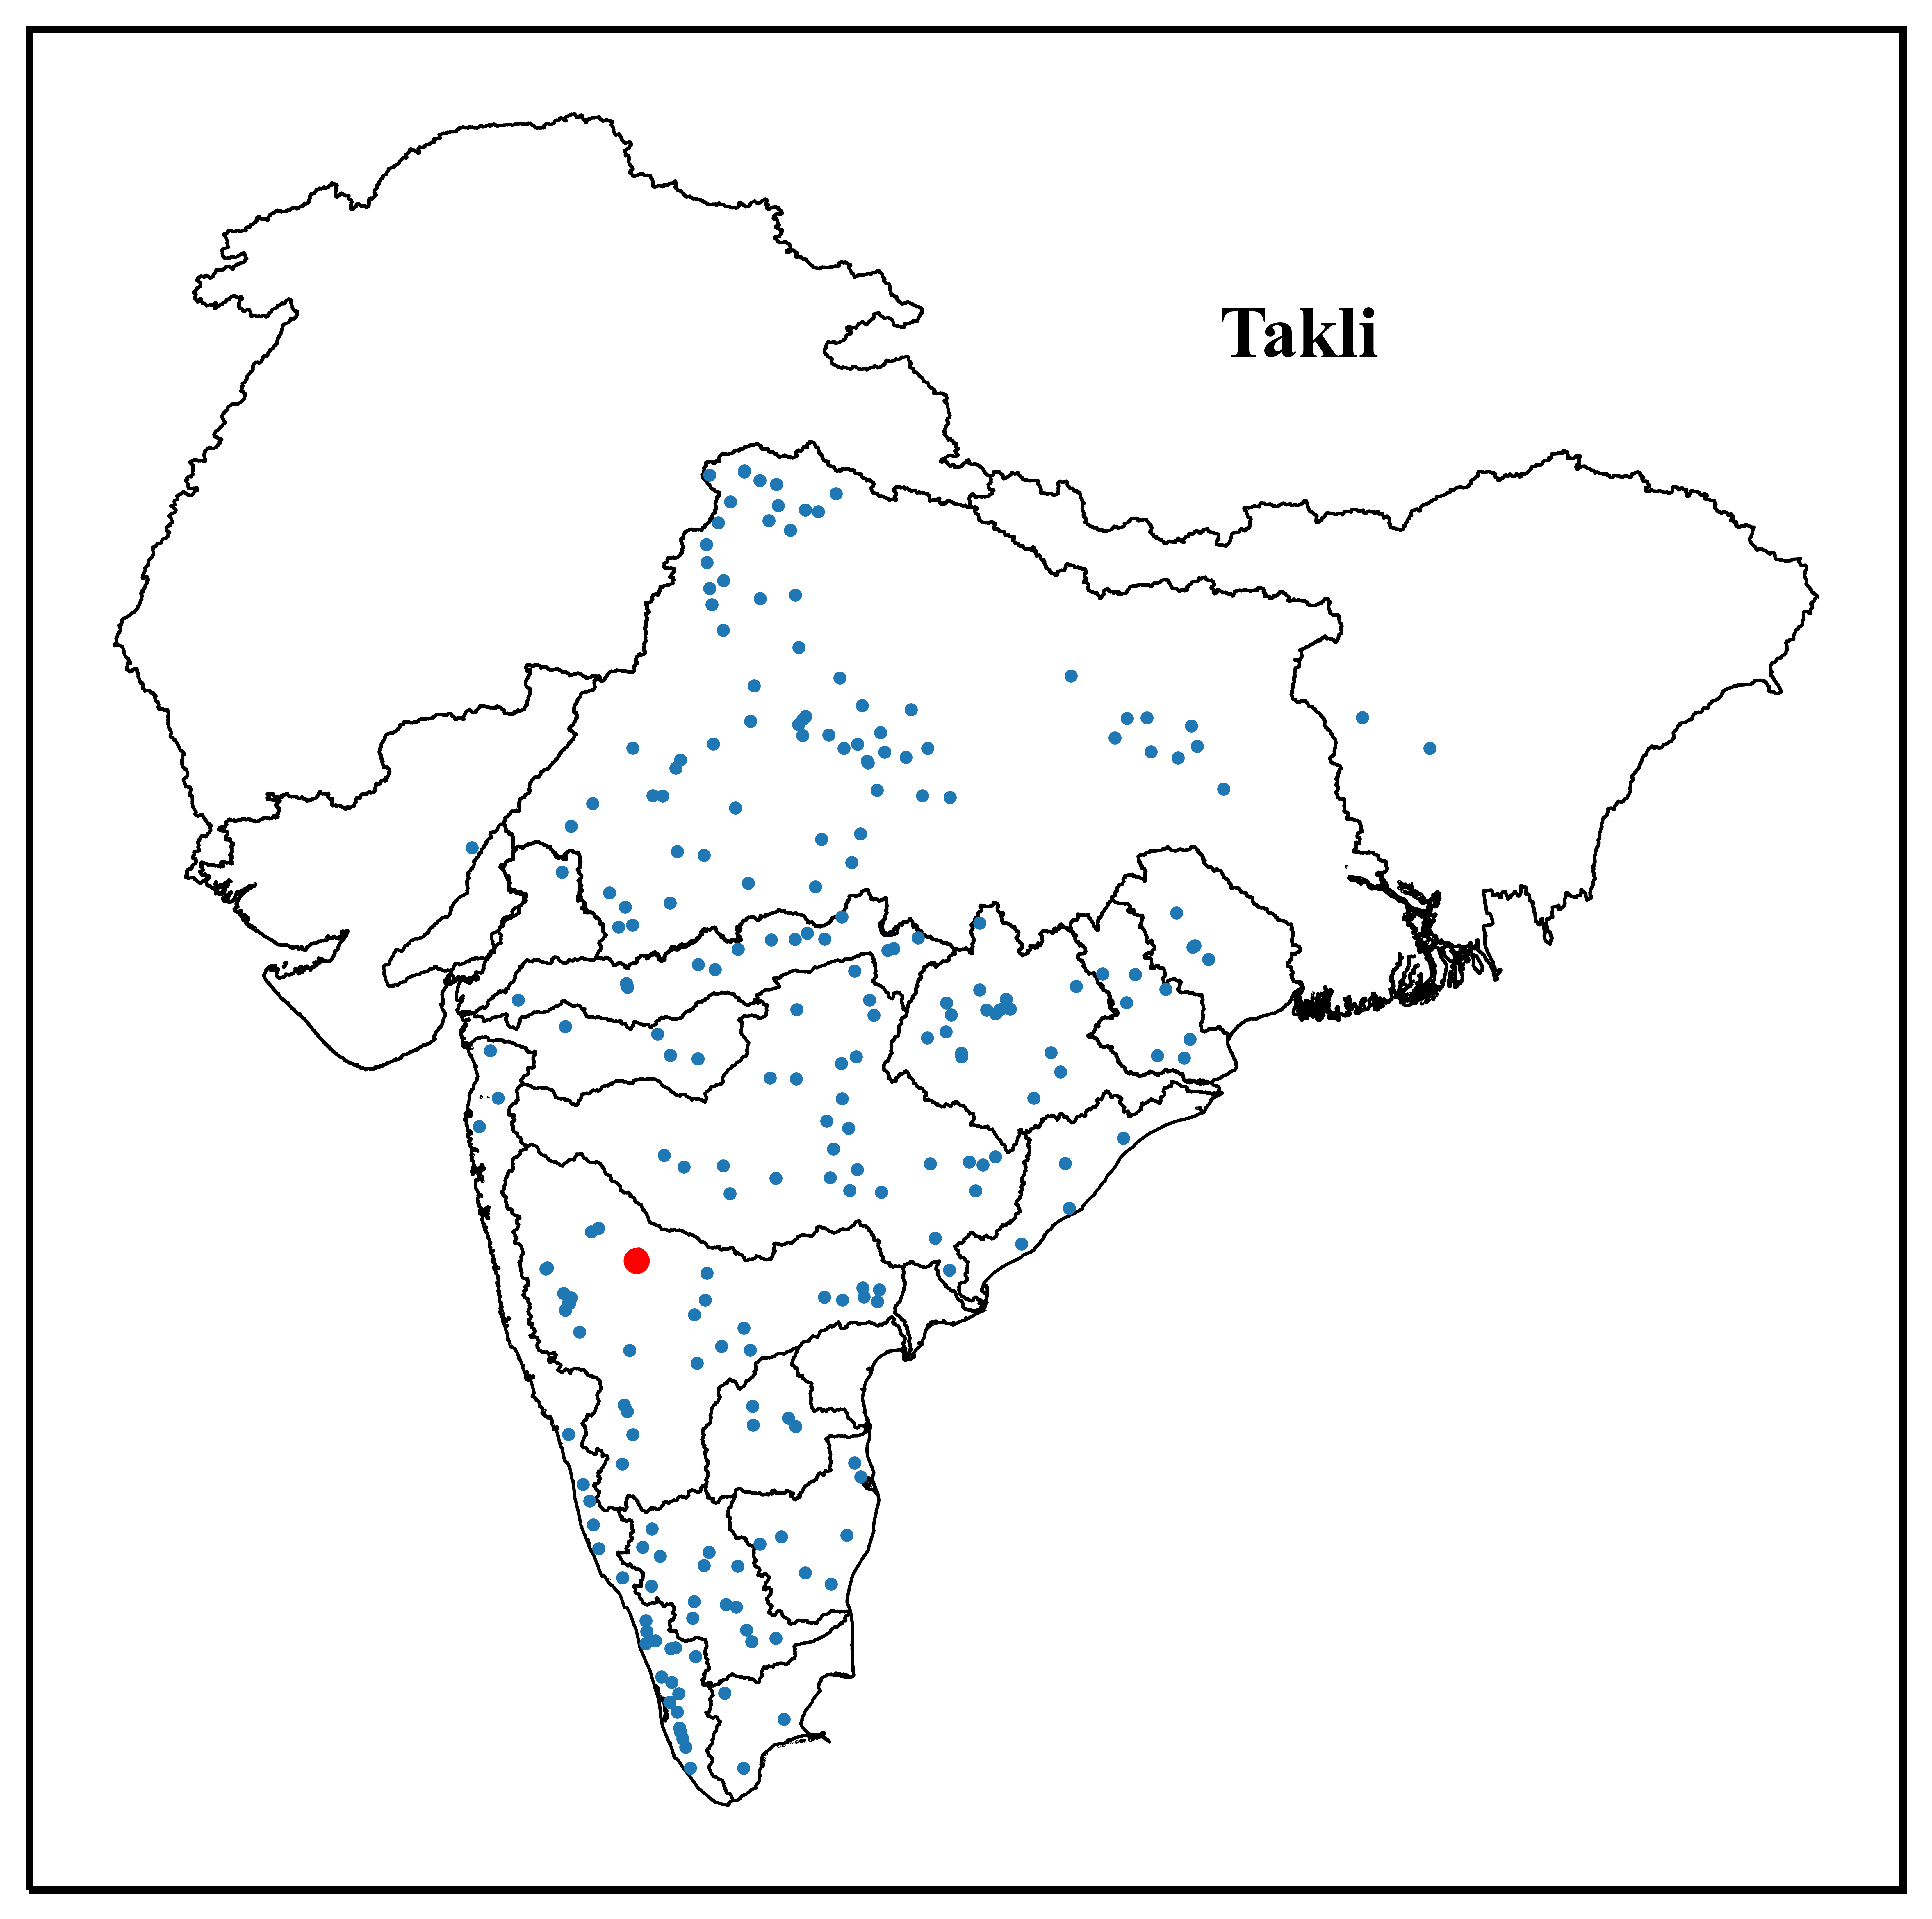

In [238]:

gauge_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv')



plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.serif"] = "Times New Roman"



df=pd.DataFrame(index=tim,columns=['ILDAS','Gauge'])


stn=station_new[1]

df['Gauge']=ds['streamflow'].sel(station=stn,time=tim)

fig, ax0 = plt.subplots(1, 1, figsize=(7,7), subplot_kw={"projection": ccrs.PlateCarree()},dpi=1000)


# # Plot 2 - Map
south_asia.plot(ax=ax0, color='none', edgecolor='Black', linewidth=0.8, alpha=1)
[x.set_linewidth(1.8) for x in ax0.spines.values()] 
#ax0.coastlines(resolution='110m', linewidth=1)

ax0.scatter(gauge_info['Longitude'],gauge_info['Latitude'],s=5)
ax0.scatter(gauge_info[gauge_info['Station']==stn]['Longitude'],gauge_info[gauge_info['Station']==stn]['Latitude'],color='red',s=30)


#ax0.set_title(stations[0].values)

ax0.text(0.72, 0.85, stn, fontsize=18, color='black',weight='bold',ha='right', va='top', transform=ax0.transAxes)

# Adjust the layout to avoid overlap
fig.tight_layout(pad=2.0)  # Increase padding if needed


#plt.savefig(f'2_Streamflow_Analysis/2_basic_statistics/Outputs/Timeseries plots/{i+1}_{stn}.jpeg')
#plt.close(fig)







## Function - Timeseries

In [ ]:
gauge_info=pd.read_csv('3_Data/Data_p/2_Station/gauge_info_p.csv',index_col=0)
gauge_info1=gauge_info.iloc[:,1:5]
gauge_sf=xr.open_dataset(f'3_Data/Data_p/2_Station/Gauge_streamflow.nc')
south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')

gauge_sf_m=gauge_sf.resample(time='M').mean()

tim=pd.date_range(start="1980-01", end="2020-12", freq="M")

stations=gauge_sf_m['station'].values
tim=pd.date_range(start="1980-01", end="2020-12", freq="M").to_numpy(dtype='datetime64[ns]')


In [ ]:

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.serif"] = "Times New Roman"



df=pd.DataFrame(index=tim,columns=['ILDAS','Gauge'])

for i,stn in tqdm(enumerate(stations)):

    df['Gauge']=gauge_sf_m['streamflow'].sel(station=stn,time=tim)
    df['ILDAS']=ILDAS_sf_m['streamflow'].sel(station=stn,time=tim)

    fig = plt.figure(figsize=(10, 12))
    gs = fig.add_gridspec(2, 1, height_ratios=[2.7, 1])  # Controls the height ratio of subplots

    # Plot 1 - Timeseries
    ax1 = fig.add_subplot(gs[1])  
    ax1.plot(tim, df['Gauge'], color='blue', label='Gauge', alpha=1, linewidth=1.3)
    ax1.plot(tim, df['ILDAS'], color='red', label='ILDAS', alpha=1, linewidth=1,linestyle='--')


    [x.set_linewidth(1.4) for x in ax1.spines.values()]

    ax1.set_xlabel('Time',fontsize=14,labelpad=7,weight='bold')
    ax1.set_ylabel('Streamflow',fontsize=14,labelpad=7,weight='bold')
    ax1.tick_params(which='major', length=0)
    ax1.tick_params(which='minor', length=0)
    #ax1.set_ylim(22,33)

    lgnd=plt.legend(loc='center', ncol=2,fontsize=13, bbox_to_anchor=(0.79, 0.92),frameon=True, borderpad=0.32, edgecolor='black')
    frame = lgnd.get_frame()
    frame.set_linewidth(0.8)

    # # Plot 2 - Map
    ax0 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())  # Set the projection for the map
    south_asia.plot(ax=ax0, color='none', edgecolor='Black', linewidth=0.8, alpha=1)
    [x.set_linewidth(1.8) for x in ax0.spines.values()] 
    #ax0.coastlines(resolution='110m', linewidth=1)

    ax0.scatter(gauge_info1['Longitude'],gauge_info1['Latitude'],s=10)
    ax0.scatter(gauge_info1[gauge_info1['Station']==stn]['Longitude'],gauge_info1[gauge_info1['Station']==stn]['Latitude'],color='red',s=80)


    #ax0.set_title(stations[0].values)

    ax0.text(0.72, 0.85, stn, fontsize=18, color='black',weight='bold',ha='right', va='top', transform=ax0.transAxes)

    # Adjust the layout to avoid overlap
    fig.tight_layout(pad=2.0)  # Increase padding if needed


    plt.savefig(f'2_Streamflow_Analysis/2_basic_statistics/Outputs/Timeseries plots/{i+1}_{stn}.jpeg')
    plt.close(fig)